# QGS model: Atmospheric model with heat exchange
## Li et al. 2017 model version
This model version is a simple 2-layer channel QG atmosphere truncated at wavenumber 2 on a beta-plane with a simple orography (a montain and a valley) , with a radiative and heat exchanges scheme inspired by the MAOOAM model.

More detail can be found in the articles:
* Li, D., He, Y., Huang, J., Bi, L., & Ding, L. (2018). *Multiple equilibria in a land–atmosphere coupled system.* Journal of Meteorological Research, **32**(6), 950-973.
[doi:10.1007/s13351-018-8012-y](https://doi.org/10.1007/s13351-018-8012-y)
* De Cruz, L., Demaeyer, J. and Vannitsem, S. (2016). *The Modular Arbitrary-Order Ocean-Atmosphere Model: MAOOAM v1.0*, Geosci. Model Dev., **9**, 2793-2808. [doi:10.5194/gmd-9-2793-2016](https://doi.org/10.5194/gmd-9-2793-2016)

or in the documentation.

## Modules import
First, setting the path and loading of some modules

In [1]:

import sys, os
sys.path.extend([os.path.abspath('../')])
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Times'],'size':14})

np.random.seed(210217) # Initializing the random number generator (for reproducibility). -- Disable if needed.

from qgs.params.params import QgParams #Importing the model's modules
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic # and diagnostics
from qgs.diagnostics.variables import VariablesDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

In [2]:
%%time
## Systems definition
#General parameters. I am selecting standard parameters for the runs below, not sure if this is what Robin is using
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 5 # it will write every `write_steps` which given the time step 0.1 would translate into two outputs per dimensionless time

number_of_trajectories = 1
number_of_perturbed_trajectories = 10

#The other parameters can come from model1.pickle that Robin prepared:
import pickle
# loading the model
with open('model1.pickle', "rb") as file:
    model = pickle.load(file)

f = model['f']
Df = model['Df']
model_parameters = model['parameters']
# Printing the model's parameters
model_parameters.print_params()

#Why did Robin choose n = 0.353? Otherwise the setup is similar to ground_heat.ipynb but with more spectral components. It is not clear to me if we need many spectral components. The typical setup with fewer components is usually enough to provide some realism. 

#Parameters that are different:
#* Atmospheric Temperature parameters
#    * 'C[1]' : 122 [W][m^-2] instead of 99 [W][m^-2]: (spectral component 1 of the short-wave radiation of the atmosphere), other C's are zero
#    * 'hlambda': 20  [W][m^-2][K^-1] instead of 10 [W][m^-2][K^-1] (sensible+turbulent heat exchange between ocean and atmosphere),
#* Ground Parameters:
#    * 'hk[2]': 0.4 instead of 0.2    (spectral components 2 of the orography), other h'k are zero
#* Ground Temperature Parameters:
#    * 'gamma': 200000000  [J][m^-2][K^-1] instead of 16000000  (specific heat capacity of the ground),
#    * 'C[1]': 280.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of the ground), other C parameters are zero

Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 0.353    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.1  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.01  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 112.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of t

/home/scratch01/gmiloshe/tests/qgs/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +


In [3]:
#Below we can also investigate what fields that are actually used 
# model_parameters.latex_var_string

trajfilename = 'modeltraj2.pickle' # to create new trajectories rename the file or remove it form the directory

if not os.path.exists(trajfilename): 
    f, Df = create_tendencies(model_parameters)
    print('tendencies created')
    ## Time integration
    #Defining an integrator
    integrator = RungeKuttaIntegrator()
    integrator.set_func(f)
    #Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors. I kept the standard time that is typically used in other runs, so not sure if it perfectly adapted...
    print('integrator set up')
    ic = np.random.rand(model_parameters.ndim)*0.1
    integrator.integrate(0., 300000., dt, ic=ic, write_steps=write_steps)
    time, traj = integrator.get_trajectories()
    
    
    print(f'saving {trajfilename}')
    with open(trajfilename, 'wb') as file:
        pickle.dump([time,traj], file)
else:
    print(f'loading {trajfilename}')
    with open(trajfilename, "rb") as file:
        [time,traj] = pickle.load(file)
reference_time, reference_traj = time[200000:],traj[:,200000:]

loading modeltraj2.pickle


Below we are checking how long the spin-up takes (when we reach stationary probability measure)

(-4.0, 4.0)

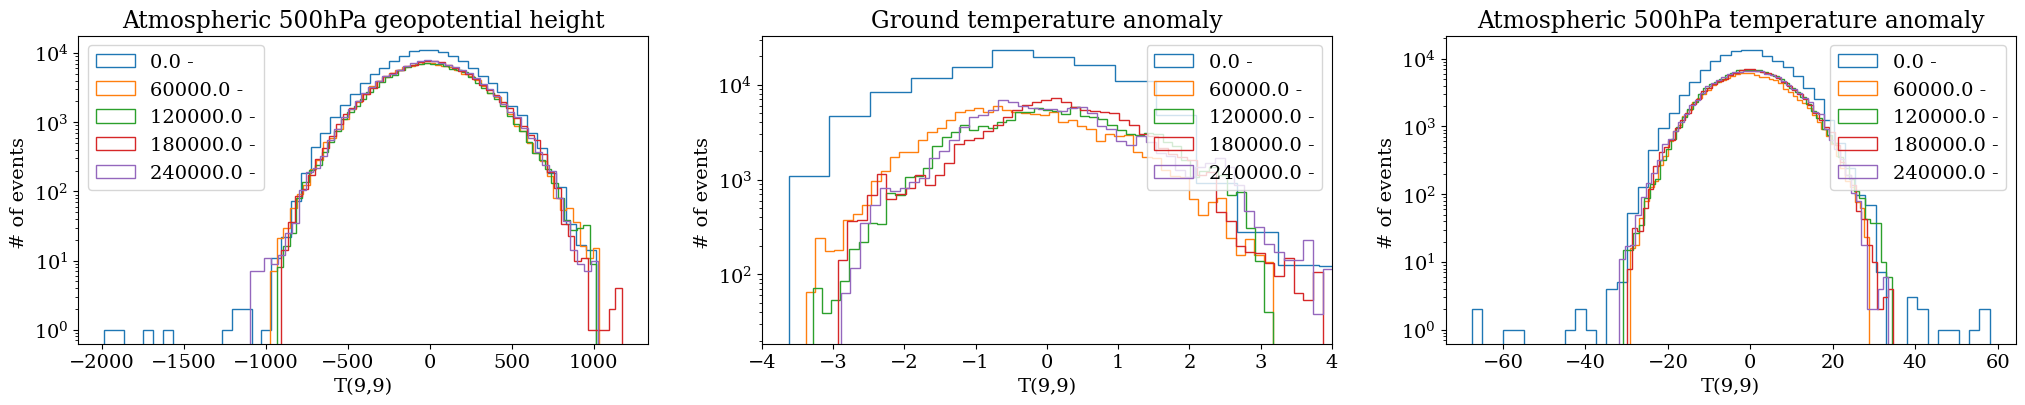

In [5]:
from qgs.diagnostics.temperatures import GroundTemperatureDiagnostic
psi = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)
groundT = GroundTemperatureDiagnostic(model_parameters, True)
from qgs.diagnostics.temperatures import MiddleAtmosphericTemperatureDiagnostic
MiddleT = MiddleAtmosphericTemperatureDiagnostic(model_parameters, True)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,4),constrained_layout=False)
len_time=len(time)
x, y = 9, 9 # trajectories of the point of interest
for j, field in enumerate([psi,groundT,MiddleT]):
    field.set_data(time, traj)
    field.climatology = np.mean(field.diagnostic,0)
    field.std = np.std(field.diagnostic,0)
    field.anomaly = field.diagnostic - field.climatology
    for i in range(5):
        time_i = i*len_time//5
        time_f = (i+1)*len_time//5
        axs[j].hist(field.anomaly[time_i:time_f,x,y], histtype='step',  bins=50,label=f'{time[time_i]} -')
    axs[j].set_ylabel('# of events ')
    axs[j].set_xlabel(f'T({x},{y})')
    axs[j].legend(loc='best')
    axs[j].set_yscale('log')
    axs[j].set_title(field._plot_title)
axs[1].set_xlim([-4,4])

We now work with the series which have the first 2 thirds subtracted (as usually done). This corresponds to red and purple distributions, which seeem to be nicely equilibrated

In [5]:
from qgs.diagnostics.temperatures import GroundTemperatureDiagnostic

groundT = GroundTemperatureDiagnostic(model_parameters, True)
groundT.set_data(reference_time, reference_traj)
groundT.climatology = np.mean(groundT.diagnostic,0)
print(f'{groundT.climatology[9,9] = }')


groundT.climatology[9,9] = 1.7421561942416885


Why is there average temperature? I was expecting that groundT corresponds to the anomaly.We now show some simple statistics of the temperature fluctuations in the middle. In principle any location except the edges would be ok: on the edges we have boundary conditions.

To find the physical time I have looked at 333 of `qgs/diagnostics/base.py` for the defintion of the title of `plot` method (also we can find the access to the physical fields (`diagnostic`) there)
```
                title += " at " + "{:.2f}".format(self._model_params.dimensional_time * self._time[time_index]) + " " + self._model_params.time_unit
```
there might be a better way to do this but I don't know it

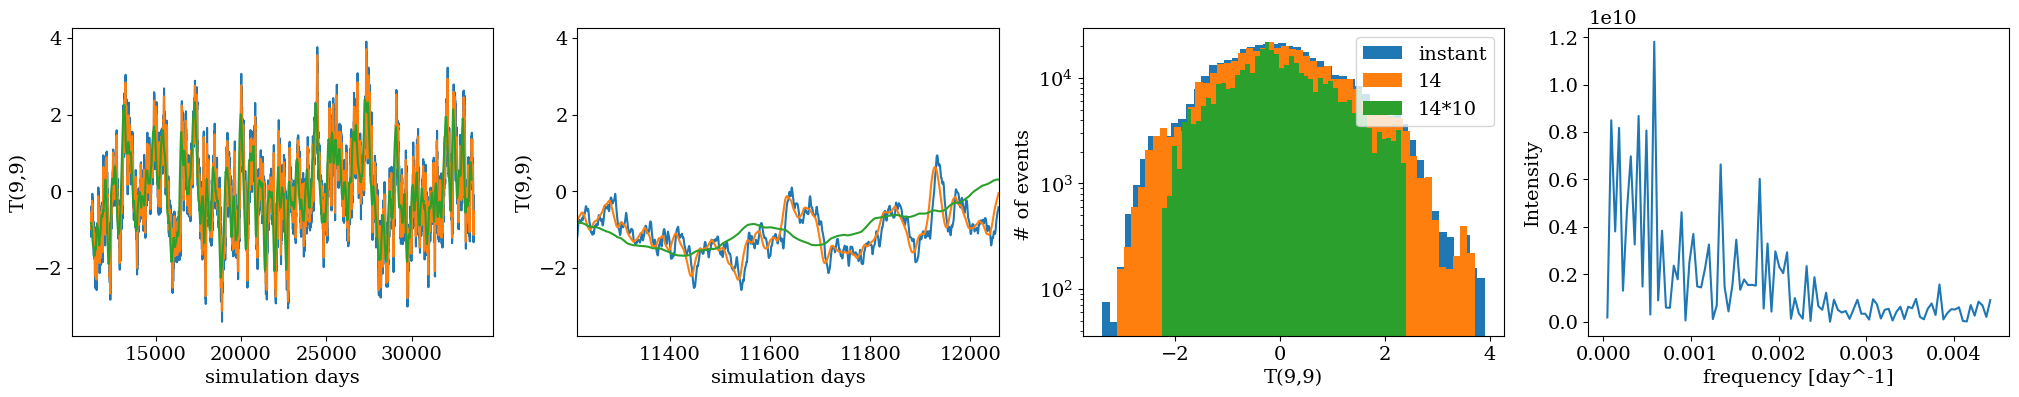

In [6]:
x, y = 9, 9
instanteneous = groundT.diagnostic[:,x, y] - groundT.climatology[x,y]
timedimensional = groundT._time*groundT._model_params.dimensional_time
timeavg1 = np.convolve(instanteneous,  np.ones(18*14)/(18*14), mode='valid') # 14 simulation days
timeavg2 = np.convolve(instanteneous,  np.ones(18*14*10)/(18*14*10), mode='valid') # 14*20 simulation days
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25,4),constrained_layout=False)
axs[0].plot(timedimensional,instanteneous)
axs[0].plot(timedimensional[:len(timeavg1)],timeavg1)
axs[0].plot(timedimensional[:len(timeavg2)],timeavg2)
axs[0].set_xlabel('simulation days')
axs[0].set_ylabel(f'T({x},{y})')
axs[1].plot(timedimensional,instanteneous)
axs[1].plot(timedimensional[:len(timeavg1)],timeavg1)
axs[1].plot(timedimensional[:len(timeavg2)],timeavg2)
axs[1].set_xlabel('simulation days')
axs[1].set_ylabel(f'T({x},{y})')
axs[1].set_xlim([timedimensional[0],timedimensional[15000]])
axs[2].hist(instanteneous, bins=50,label='instant')
axs[2].hist(timeavg1, bins=50,label='14')
axs[2].hist(timeavg2, bins=50,label='14*10')
axs[2].set_ylabel('# of events ')
axs[2].set_xlabel(f'T({x},{y})')
axs[2].legend(loc='best')
axs[2].set_yscale('log')

sp = np.fft.fft(instanteneous)
freq = np.fft.fftfreq(instanteneous.shape[-1])
axs[3].plot(freq[1:100]/(timedimensional[1]-timedimensional[0]), 2*np.abs(sp[1:100])**2)
axs[3].set_xlabel('frequency [day^-1]')
axs[3].set_ylabel('Intensity')
plt.show()

In [11]:
groundT._model_params.dimensional_time, len(groundT._time), groundT._time[-1], time[-1]

(0.11215188056273327, 400001, 300000.0, 300000.0)

So the time series are not teribly realistic, if we compare it to how it should look (reanalysis or a climate model). One expects larger daily fluctuations, whereas here we get monthly dynamics modulated by small synoptic noise. there is no seasonal or daily cycle yet dynamics is dominated by fluctuations on long time scales. The problem is that this system has attractors related to blocking and is unlike, say, Plasim. Below I show a small period as well as the autocorrelation time that reveals the typical time scale could be of order 100 days, which probably corresponds to the period of hoping between different attractors present in the system

series_bootstrapped.shape =(10, 40000)
autocorr.shape = (10, 5000)
autocorr.shape = (10, 5000), autocorr_mean.shape = (5000,),autocorr_std.shape = (5000,)
series.reshape(1,-1).shape = (1, 400000)


Text(0, 0.5, 'T(9,9)')

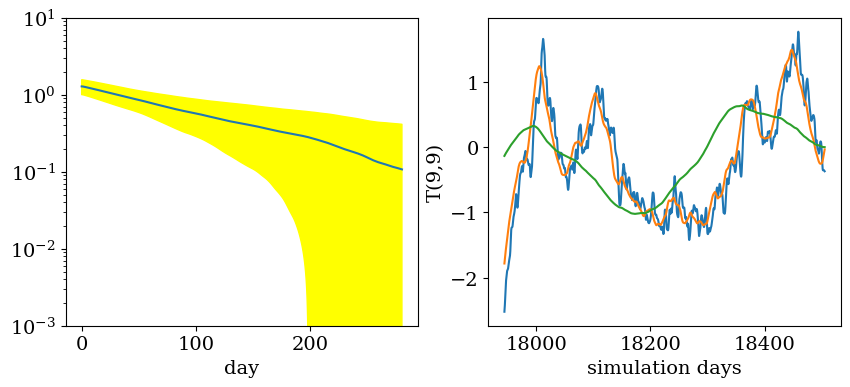

In [42]:

def autocorrelation(myseries, maxlag):
    # this pads each year with padsize sample time of 0s so that when the array is permuted to be multiplied by itself we don't end up using the previous part of the year
    series_pad = np.pad(myseries,((0, 0), (0, maxlag)), 'constant')  
    autocorr = []
    for k in range(maxlag):
        autocorr.append(np.sum(series_pad*np.roll(series_pad, -k))/(series_pad.shape[0]*(series_pad.shape[1]-k-maxlag)))
    return autocorr

def PltAutocorrelation(series_in,bootstrapnumber,timelenx,ax):
    autocorr = []
    series = series_in[:bootstrapnumber*(len(series_in)//bootstrapnumber)] # remove the extra stuff
    series_bootstrapped = series.reshape(bootstrapnumber,-1)
    print(f'{series_bootstrapped.shape =}')
    for i in range(bootstrapnumber):
        autocorr.append(autocorrelation(series_bootstrapped[i:(i+1),:],timelenx))
    autocorr = np.array(autocorr)#/np.std(t2m.abs_area_int[i:(i+1),:])**2 # uncomment this is autocorrelation is seeked for (so that at time = 0 it is normalized to 1)
    print(f'{autocorr.shape = }')
    autocorr_mean = np.mean(autocorr,0)
    autocorr_std = np.std(autocorr,0)
    print(f'{autocorr.shape = }, {autocorr_mean.shape = },{autocorr_std.shape = }')
    ax.fill_between((groundT._time[:len(autocorr_mean)]*groundT._model_params.dimensional_time)-(groundT._time[0]*groundT._model_params.dimensional_time), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='yellow')
    print(f'{series.reshape(1,-1).shape = }')
    full_auto = autocorrelation(series.reshape(1,-1),timelenx)
    ax.plot((groundT._time[:len(full_auto)]*groundT._model_params.dimensional_time)-(groundT._time[0]*groundT._model_params.dimensional_time),full_auto,label='Gaussian')
    return autocorr_mean, autocorr_std

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4),constrained_layout=False)

bootstrapnumber = 10
autocorr_mean,autocorr_std = PltAutocorrelation(instanteneous,bootstrapnumber,5000,axs[0])
axs[0].set_xlabel('day')
axs[0].set_yscale('log')
axs[0].set_ylim([1e-3,1e1])

time_start = 120000
time_end = 130000
axs[1].plot(timedimensional[time_start:time_end],instanteneous[time_start:time_end])
axs[1].plot(timedimensional[time_start:time_end],timeavg1[time_start:time_end])
axs[1].plot(timedimensional[time_start:time_end],timeavg2[time_start:time_end])
axs[1].set_xlabel('simulation days')
axs[1].set_ylabel(f'T({x},{y})')

We can also see that the orange curve representing T day average follows closely the instantaneous dynamics (blue) which indicates the time average and instantantenous statistics are going to be very similar. Below we compute the 14 day extremes 

In [43]:
def ComputeTimeAverage(series,T=14*18,tau=0, percent=5, threshold=None): 
        '''
        Computes running mean from time series
        '''
        print(f'{T = }')
        convseq = np.ones(T)/T
        A=np.convolve(series,  convseq, mode='valid')
        if threshold is None:
            threshold = np.sort(A)[np.ceil(A.shape[0]*(1-percent/100)).astype('int')]
        list_extremes = list(A >= threshold)
        print(f'{len(list_extremes) = }')
        return A, threshold, list_extremes, convseq
A, threshold, list_extremes, convseq = ComputeTimeAverage(instanteneous)
print(f'{threshold = }, {np.sum(list_extremes)/len(list_extremes) = }')

T = 252
len(list_extremes) = 399750
threshold = 1.9913001751431474, np.sum(list_extremes)/len(list_extremes) = 0.04999874921826141


Compute standard climatology

In [44]:
psi = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)
groundT = GroundTemperatureDiagnostic(model_parameters, True)
from qgs.diagnostics.temperatures import MiddleAtmosphericTemperatureDiagnostic
MiddleT = MiddleAtmosphericTemperatureDiagnostic(model_parameters, True)

for field in [psi,groundT,MiddleT]:
    field.set_data(reference_time, reference_traj)
    field.climatology = np.mean(field.diagnostic,0)
    field.std = np.std(field.diagnostic,0)
    field.anomaly = field.diagnostic - field.climatology
    field.extmean = np.mean(field.anomaly[np.where(np.array(list_extremes) == True)[0],...],0)
    field.extstd = np.std(field.anomaly[np.where(np.array(list_extremes) == True)[0],...],0)



We plot the climatology of middle atmosphere geopotential along with the composite map conditioned to 5 percent extremes

/tmp/ipykernel_19374/605569581.py:6: UserWarning: The following kwargs were not used by contour: 'linewdiths'
  cs1 = axs[0,iter].contour(field._X, field._Y, field.std, colors='black', linewdiths=5) #, cmap="Greens")
/tmp/ipykernel_19374/605569581.py:7: UserWarning: The following kwargs were not used by contour: 'linewdiths'
  cs2 = axs[0,iter].contour(field._X, field._Y, field.std, colors='white', linewdiths=.5) #, cmap="Greens")


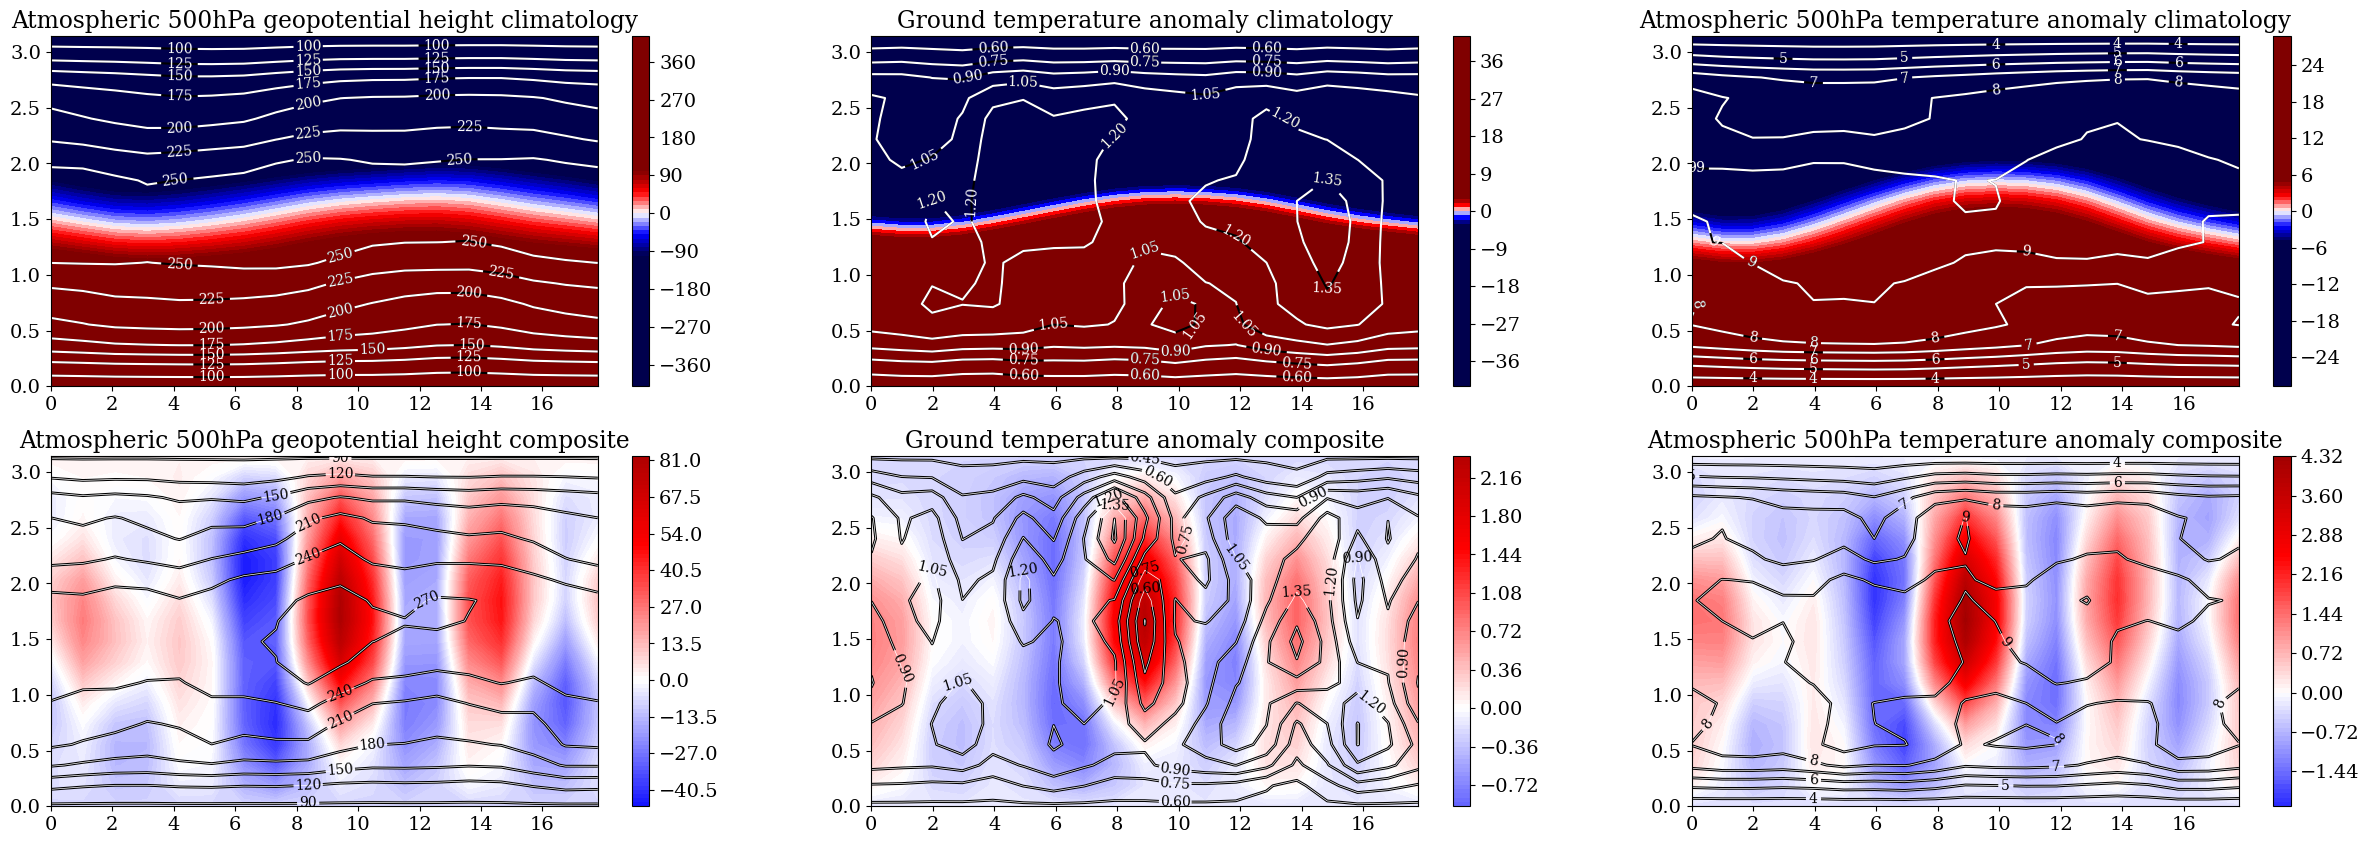

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30,10),constrained_layout=False)


for iter, field_margin, field in zip(range(3),[100,3,5],[psi,groundT,MiddleT]):
    cs0 = axs[0,iter].contourf(field._X, field._Y, field.climatology, cmap="seismic", levels=100, vmin=-field_margin, vmax=field_margin)
    cs1 = axs[0,iter].contour(field._X, field._Y, field.std, colors='black', linewdiths=5) #, cmap="Greens")
    cs2 = axs[0,iter].contour(field._X, field._Y, field.std, colors='white', linewdiths=.5) #, cmap="Greens")
    axs[0,iter].clabel(cs1, inline=True, fontsize=10)
    axs[0,iter].clabel(cs2, inline=True, fontsize=10)
    fig.colorbar(cs0, ax=axs[0,iter])
    axs[0,iter].set_title(field._plot_title+' climatology')

    cs0 = axs[1,iter].contourf(field._X, field._Y, field.extmean, cmap="seismic", levels=100, vmin=-field_margin, vmax=field_margin)
    cs1 = axs[1,iter].contour(field._X, field._Y, field.extstd, colors='black', linewidths=2) #, cmap="Greens")
    cs12 = axs[1,iter].contour(field._X, field._Y, field.extstd, colors='white', linewidths=.5) #, cmap="Greens")
    axs[1,iter].clabel(cs1, inline=True, fontsize=10)
    axs[1,iter].clabel(cs2, inline=True, fontsize=10)
    fig.colorbar(cs0, ax=axs[1,iter])
    axs[1,iter].set_title(field._plot_title+' composite')
plt.show()

While there are some differences between climatology and the composite map, given the variance of the geopotential (dimensionalized parotropic stream function) it is not obvious that this information is enough to make a prediction. Interestingly the ground temperature distribution is far from random here. One would expect that it should be an important predictor. Middle atmospheric anomaly (baroclinic stream function) might also be useful.

T = 2520
len(list_extremes) = 397482
threshold = 1.6783401716726882, np.sum(list_extremes)/len(list_extremes) = 0.049999748416280486


/tmp/ipykernel_19374/1421686462.py:11: UserWarning: The following kwargs were not used by contour: 'linewdiths'
  cs1 = axs[0,iter].contour(field._X, field._Y, field.std, colors='black', linewdiths=5) #, cmap="Greens")
/tmp/ipykernel_19374/1421686462.py:12: UserWarning: The following kwargs were not used by contour: 'linewdiths'
  cs2 = axs[0,iter].contour(field._X, field._Y, field.std, colors='white', linewdiths=.5) #, cmap="Greens")


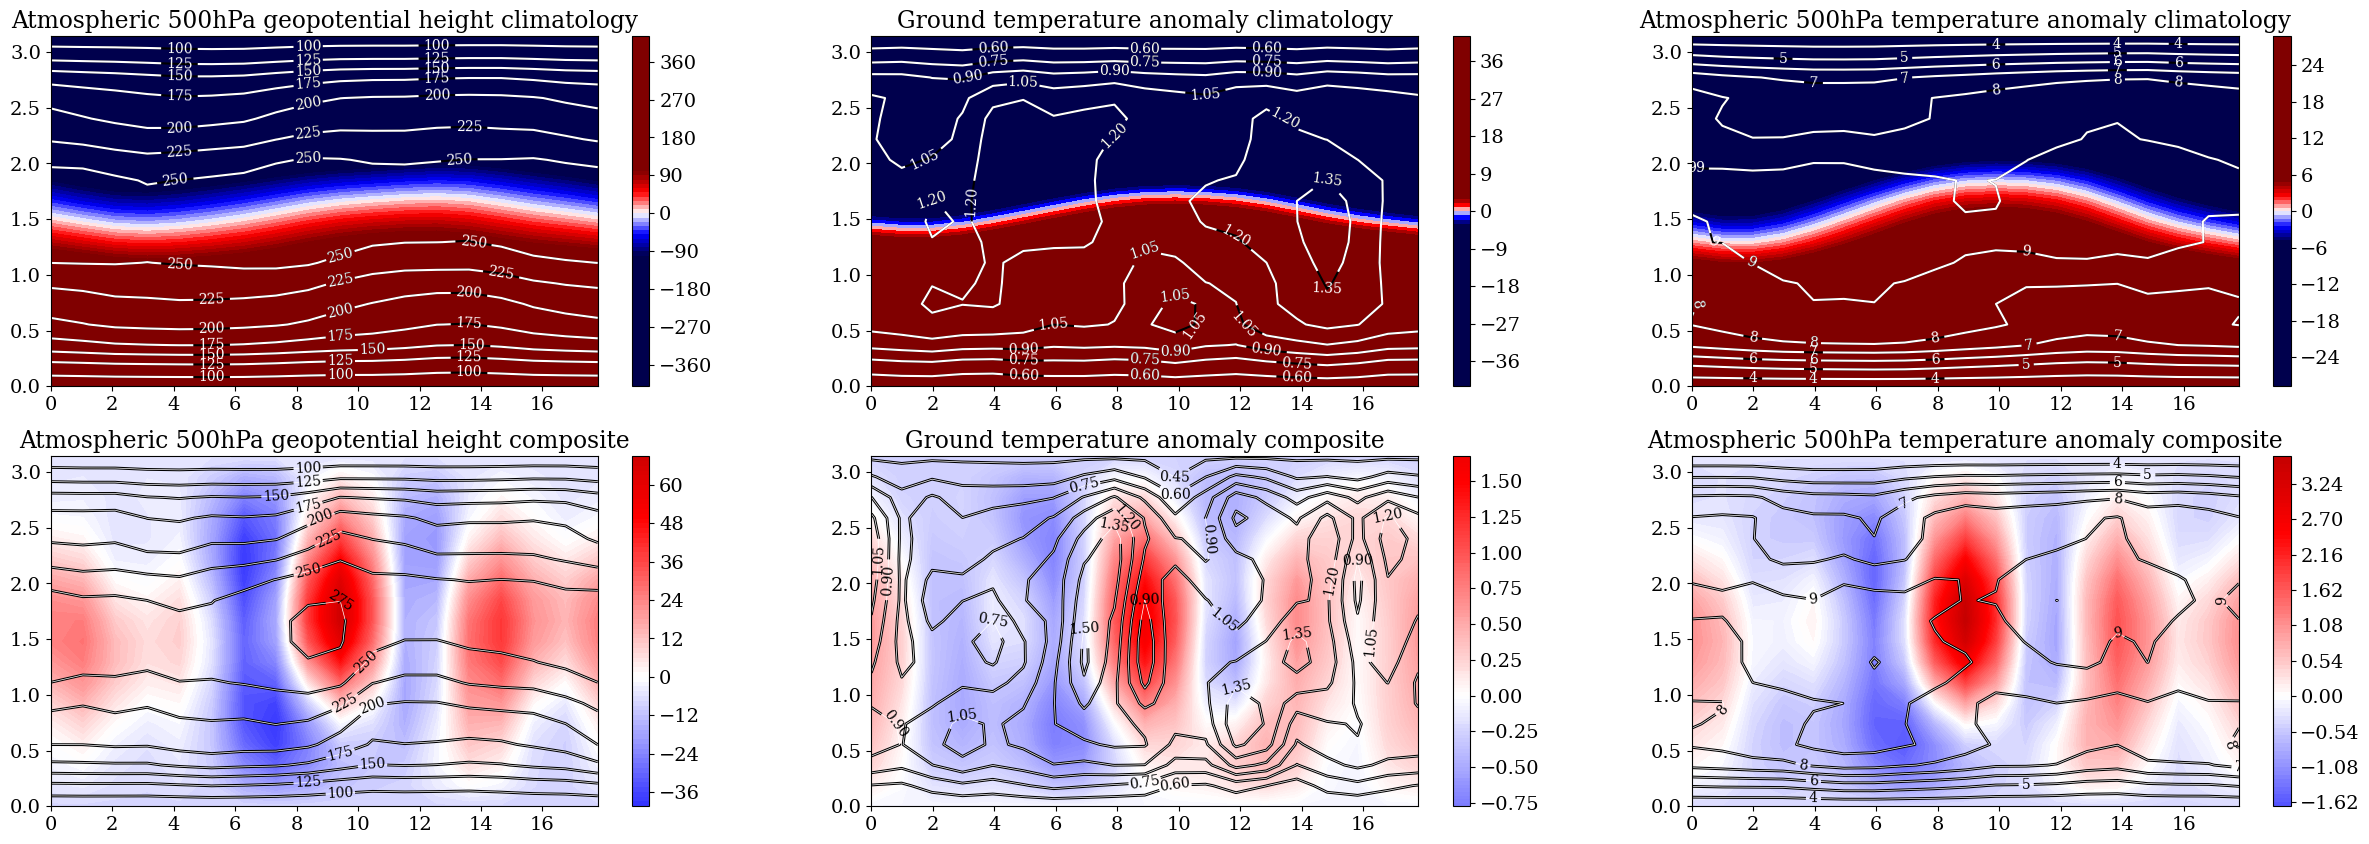

In [46]:
A, threshold, list_extremes, convseq = ComputeTimeAverage(instanteneous,T=14*18*10)
print(f'{threshold = }, {np.sum(list_extremes)/len(list_extremes) = }')
for field in [psi,groundT,MiddleT]:
    field.extmean = np.mean(field.anomaly[np.where(np.array(list_extremes) == True)[0],...],0)
    field.extstd = np.std(field.anomaly[np.where(np.array(list_extremes) == True)[0],...],0)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30,10),constrained_layout=False)


for iter, field_margin, field in zip(range(3),[100,3,5],[psi,groundT,MiddleT]):
    cs0 = axs[0,iter].contourf(field._X, field._Y, field.climatology, cmap="seismic", levels=100, vmin=-field_margin, vmax=field_margin)
    cs1 = axs[0,iter].contour(field._X, field._Y, field.std, colors='black', linewdiths=5) #, cmap="Greens")
    cs2 = axs[0,iter].contour(field._X, field._Y, field.std, colors='white', linewdiths=.5) #, cmap="Greens")
    axs[0,iter].clabel(cs1, inline=True, fontsize=10)
    axs[0,iter].clabel(cs2, inline=True, fontsize=10)
    fig.colorbar(cs0, ax=axs[0,iter])
    axs[0,iter].set_title(field._plot_title+' climatology')

    cs0 = axs[1,iter].contourf(field._X, field._Y, field.extmean, cmap="seismic", levels=100, vmin=-field_margin, vmax=field_margin)
    cs1 = axs[1,iter].contour(field._X, field._Y, field.extstd, colors='black', linewidths=2) #, cmap="Greens")
    cs12 = axs[1,iter].contour(field._X, field._Y, field.extstd, colors='white', linewidths=.5) #, cmap="Greens")
    axs[1,iter].clabel(cs1, inline=True, fontsize=10)
    axs[1,iter].clabel(cs2, inline=True, fontsize=10)
    fig.colorbar(cs0, ax=axs[1,iter])
    axs[1,iter].set_title(field._plot_title+' composite')
plt.show()

In [44]:
groundT.std_regularized = groundT.std.copy()
groundT.std_regularized[groundT.std_regularized==0] = 1
X_tr = (groundT.diagnostic[:len(list_extremes),...] - groundT.climatology)/groundT.std_regularized

y_tr = np.array(list_extremes)
print(f'{X_tr.shape = }, {y_tr.shape = }')

import tensorflow as tf
from tensorflow.keras import regularizers, Input, Model

def create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9):
    inputs = Input(shape=model_input_dim) # Create a standard model (alternatively we can use our function my_create_logistic_model which builds a custom sequential model
    x = tf.keras.layers.Flatten(input_shape=model_input_dim)(inputs)
    if regularizer == 'none':
        outputs = tf.keras.layers.Dense(2)(x)
    elif regularizer == 'l2':
        outputs = tf.keras.layers.Dense(2, kernel_regularizer=regularizers.l2(regularizer_coef))(x)
    else:
        outputs = tf.keras.layers.Dense(2, kernel_regularizer=regularizers.l1(regularizer_coef))(x)
    model = Model(inputs=inputs, outputs=outputs)   # alternatively we can write:     model = MyModel(inputs=inputs, outputs=outputs)
    return model

model_input_dim = X_tr.shape[1:] #(X.shape[1],X.shape[2])
model = create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9)

X_tr.shape = (197482, 18, 19), y_tr.shape = (197482,)


In [50]:
from tensorflow import keras
#### Custom Metrics ######

class UnbiasedMetric(keras.metrics.Metric):
    def __init__(self, name, undersampling_factor=1, **kwargs):
        super().__init__(name=name, **kwargs)
        self.undersampling_factor = undersampling_factor
        self.r = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)

    
class MCCMetric(UnbiasedMetric): # This function is designed to produce confusion matrix during training each epoch
    def __init__(self, num_classes=2, threshold=None, undersampling_factor=1, name='MCC', **kwargs):
        '''
        Mathews correlation coefficient metric

        Parameters
        ----------
        num_classes : int, optional
            number of classes, by default 2
        threshold : float, optional
            If num_classes == 2 allows to choose a threshold over which to consider an event positive. If None the event is positive if it has probability higher than 0.5. By default None
        '''
        super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.threshold = threshold
        if self.num_classes != 2:
            raise NotImplementedError('MCC works only with 2 classes')
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
    
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
    
    @tf.autograph.experimental.do_not_convert
    def result(self):
        #return self.process_confusion_matrix()
        cm=self.total_cm
        
        #return cm
        TN = cm[0,0]
        FP = cm[0,1]
        FN = cm[1,0]
        TP = cm[1,1]
        MCC_den = ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        MCC = (TP * TN - FP *FN)/tf.sqrt(MCC_den)
        return tf.cond(MCC_den == 0, lambda: tf.constant(0, dtype=tf.float32), lambda: MCC)
    
    def confusion_matrix(self,y_true, y_pred): # Make a confusion matrix
        if self.undersampling_factor > 1 or self.threshold is not None:
            y_pred = keras.layers.Softmax()(y_pred + self.r) # apply shift of logits and softmax to convert to balanced probabilities
        if self.threshold is None:
            y_pred=tf.argmax(y_pred,1)
        else:
            y_pred = tf.cast(y_pred[:,1] > self.threshold, tf.int8)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def fill_output(self,output):
        results=self.result()
        
class ConfusionMatrixMetric(UnbiasedMetric): # This function is designed to produce confusion matrix during training each epoch
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes, undersampling_factor=1, name='confusion_matrix', **kwargs):
        super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        #return self.process_confusion_matrix()
        cm=self.total_cm
        return cm
    
    def confusion_matrix(self,y_true, y_pred): # Make a confusion matrix
        if self.undersampling_factor > 1:
            y_pred = keras.layers.Softmax()(y_pred + self.r) # apply shift of logits and softmax to convert to balanced probabilities
        
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def fill_output(self,output):
        results=self.result()

class BrierScoreMetric(UnbiasedMetric):
    def __init__(self, undersampling_factor=1, name='BrierScore', **kwargs):
        super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs)
        self.mse = keras.metrics.MeanSquaredError()
        self.my_metric = self.add_weight(name='BScore', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        _ = self.mse.update_state(y_true, keras.layers.Softmax()(y_pred + self.r))
        self.my_metric.assign(self.mse.result())

    def result(self):
        return self.my_metric

class UnbiasedCrossentropyMetric(UnbiasedMetric):

  def __init__(self, undersampling_factor=1, name='UnbiasedCrossentropy', **kwargs):
    super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs)
    self.my_metric = self.add_weight(name='CLoss', initializer='zeros')
    self.m = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)

  def update_state(self, y_true, y_pred, sample_weight=None):
    #_ = self.m.update_state(tf.cast(y_true, 'int32'), y_pred)
    _ = self.m.update_state(y_true, y_pred+self.r) # the idea is to add the weight factor inside the logit so that we effectively change the probabilities
    self.my_metric.assign(self.m.result())
    
  def result(self):
    return self.my_metric


# same as above but less elegant
class CustomLoss(tf.keras.metrics.Metric):

  def __init__(self, r, name='CustomLoss', **kwargs):
    super().__init__(name=name, **kwargs)
    self.my_metric = self.add_weight(name='CLoss', initializer='zeros')
    self.r = r # undersampling_factor array (we expect the input as tf.cast(-0.5*np.log(undersampling_factor), 0.5*np.log(undersampling_factor))
    self.m = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)


  def update_state(self, y_true, y_pred, sample_weight=None):
    #_ = self.m.update_state(tf.cast(y_true, 'int32'), y_pred)
    _ = self.m.update_state(y_true, y_pred+self.r) # the idea is to add the weight factor inside the logit so that we effectively change the probabilities
    self.my_metric.assign(self.m.result())
    
  def result(self):
    return self.my_metric

  """ 
  def reset_states(self):
    # The state of the metric will be reset at the start of each epoch.
    self.my_metric.assign(0.) 
  """

class UnbiasedCrossentropyLoss(keras.losses.SparseCategoricalCrossentropy):
    '''
    This is the same as the UnbiasedCrossentropyMetric but can be used as a loss
    '''
    def __init__(self, undersampling_factor=1, name='unbiased_crossentropy_loss'):
        super().__init__(from_logits=True, name=name)
        self.r = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)

    def __call__(self, y_true, y_pred, sample_weight=None):
        return super().__call__(y_true, y_pred + self.r)

class MyMetrics_layer(tf.keras.metrics.Metric):

  def __init__(self, name='MyMetrics_layer', **kwargs):
    super(MyMetrics_layer, self).__init__(name=name, **kwargs)
    self.my_metric = self.add_weight(name='my_metric1', initializer='zeros')
    self.m = tf.keras.metrics.SparseCategoricalAccuracy()


  def update_state(self, y_true, y_pred, sample_weight=None):
    _ = self.m.update_state(tf.cast(y_true, 'int32'), y_pred)
    self.my_metric.assign(self.m.result())
    
  def result(self):
    return self.my_metric

  def reset_states(self):
    # The state of the metric will be reset at the start of each epoch.
    self.my_metric.assign(0.)
"""
class CustomLoss(tf.keras.metrics.Metric):

  def __init__(self, name='custom_loss', **kwargs):
    super(CustomLoss, self).__init__(name=name, **kwargs)
    #self.custom_loss = self.add_weight(name='closs', initializer='zeros')
    self.scce=tf.keras.losses.SparseCategoricalCrossentropy()#from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these t

  def update_state(self, y_true, y_pred, sample_weight=None):
    update_state_out = self.scce(y_true,y_pred)
    update_state_out = y_true.shape
    self.custom_loss.assign_add(update_state_out)

  def result(self):
    #return self.custom_loss
    return self.scce(y_true,y_pred)
"""
undersampling_factor = 1
tf_sampling = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)
model.summary()
#METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2)]   # the last two make the code run longer but give precise discrete prediction benchmarks
METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2),CustomLoss(tf_sampling)]#tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)]#CustomLoss()]   # the last two make the code run longer but give precise discrete prediction benchmarks
#METRICS=['loss']
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 2e-4),
    #optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their from_logits = True.
    #One advantage of using sparse categorical cross-entropy is it saves storage in memory as well as time in computation because it simply uses a single integer for a class, rather than a whole one-hot vector. This works despite the fact that the neural network has an one-hot vector output  
    metrics=METRICS   # the last two make the code run longer but give precise discrete prediction benchmarks
)
# Create a callback that saves the model's weights every saveweightseveryblaepoch epochs
model_name='test'
checkpoint_path = model_name+"/cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        verbose=1)
model.save_weights(checkpoint_path.format(epoch=0))

my_history=model.fit(X_train, Y_train, batch_size=BATCH_SIZE, validation_data=(X_test,Y_test), shuffle=True, callbacks=[cp_callback], epochs=NUM_EPOCHS,verbose=2, class_weight=class_weight)

        model.save(checkpoint_name+'/batch_'+str(i))
        np.save(checkpoint_name+'/batch_'+str(i)+'_history.npy',my_history.history)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18, 19)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 342)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 686       
                                                                 
Total params: 686
Trainable params: 686
Non-trainable params: 0
_________________________________________________________________
